### 1. Functions

In [1]:
from window_ops.rolling import rolling_mean, rolling_max, rolling_min, seasonal_rolling_mean
from numba import njit

import mlforecast
from mlforecast import MLForecast
from mlforecast import target_transforms

from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from xgboost import XGBRegressor

@njit
def diff(x, lag):
    x2 = np.full_like(x, np.nan)
    for i in range(lag, len(x)):
        x2[i] = x[i] - x[i-lag]
    return x2
@njit
def diff1(x):
    x2 = np.full_like(x, np.nan)
    lag = 1
    for i in range(lag, len(x)):
        x2[i] = x[i] - x[i-lag]
    return x2
@njit
def diff2(x):
    x2 = np.full_like(x, np.nan)
    lag = 2
    for i in range(lag, len(x)):
        x2[i] = (x[i] - x[i-lag]) / 2
    return x2
@njit
def rel1to2(x):
    eps = 1e-12
    x2 = np.full_like(x, np.nan)
    for i in range(2, len(x)):
        a = (x[i] - x[i-1])
        b = (x[i] - x[i-2])/2
        x2[i] = a/(b+eps)
    return x2


def create_feats(df, df2):
    # 1) create main table
    feats_gr = ['year', 'Continent']
    df1 = df.groupby(feats_gr).val_mt.sum().reset_index()

    # 2) sector shares with lag-3 (3 years back)
    feats_gr = ['year', 'Continent','Sector']
    df0 = df.groupby(feats_gr).val_mt.sum().unstack()
    df0 = df0.apply(lambda x: x/sum(x), axis = 1)
    cols = df0.columns
    df0.columns = ['y_'+f for f in cols]
    df0.reset_index(inplace = True)
    df0['year'] = df0['year'] + 3
    df01 = df0.copy()

    # 3) population and gdp shares
    feats_gr = [
        'year',
        'Continent',
    ]
    feats = ['population', 'gdp_gusd']
    df0 = df2.groupby(feats_gr)[feats].sum().unstack()
    df0[df0.index < 1990] = np.nan
    df0 = df0.fillna(method = 'bfill').stack()

    df0['gdp_cap'] = df0.gdp_gusd / df0.population * 10**9
    df0.reset_index(inplace = True)
    df0 = df0.merge(df1)

    df0['val_pop'] = df0['val_mt'] / df0['population'] * 10**6
    df0['val_gdp_kusd'] = df0['val_mt'] / df0['gdp_gusd']
    df0['val_gdp_cap'] = df0['val_mt'] / df0['gdp_cap']
    del df0['val_mt']

    for f in df0.columns[-6:]:
        df0[f] = df0.groupby('year')[f].apply(lambda x: x/x.sum()).values

    df0['year'] = df0['year'] + 3
    df02 = df0.copy()

    # 4) merge with main
    df_out = df1.merge(df01, how = 'left').merge(df02, how = 'left')
    df_out.rename(columns = {
        'year': 'ds',
        'Continent': 'unique_id',
        'val_mt': 'y',
    }, inplace = True)
    return df_out

In [2]:
def ts_metrics(y_true, y_pred):
    return {
        'mae': metrics.mean_absolute_error(y_true, y_pred),
        'mape': np.mean(np.abs((y_true - y_pred) / y_true)),
    }

### 2. Data

In [3]:
# read data

# main table
df = pd.read_pickle('data/df1.pkl')
print(df.shape)
display(df[:3])

# per cap and per gdp
df2 = pd.read_pickle('data/df2.pkl')
print(df2.shape)
display(df2[:3])

(255884, 7)


,Substance,Sector,EDGAR Country Code,Country,year,val_mt,Continent
0,CO2,Agriculture,AFG,Afghanistan,1970,0.03,AS
1,CO2,Agriculture,AFG,Afghanistan,1971,0.03,AS
2,CO2,Agriculture,AFG,Afghanistan,1972,0.03,AS


(11130, 13)


,EDGAR Country Code,Country,year,val_capita_ghg,val_capita_co2,Continent,val_gdp_ghg,val_gdp_co2,val_ghg,val_co2,population,gdp_gusd,gdp_cap
0,ABW,Aruba,1970,0.76,0.43,NA,NaN,NaN,0.05,0.03,"59,063.00",NaN,NaN
1,AFG,Afghanistan,1970,1.56,0.16,AS,NaN,NaN,17.34,1.73,"11,126,100.00",NaN,NaN
2,AGO,Angola,1970,2.97,1.32,AF,NaN,NaN,20.14,8.95,"6,776,380.00",NaN,NaN


In [4]:
# filters
list_filt = [
    df.Substance == 'CO2',
    df.Substance != '',
]
filt = list_filt[1]

df_feats = create_feats(df[filt], df2)
print(df_feats.shape)
df_feats[-7:]

(318, 17)


,ds,unique_id,y,y_Agriculture,y_Buildings,y_Fuel Exploitation,y_Industrial Combustion,y_Power Industry,y_Processes,y_Transport,y_Waste,population,gdp_gusd,gdp_cap,val_pop,val_gdp_kusd,val_gdp_cap
311,2021,SA,"2,563.64",0.37,0.05,0.10,0.07,0.08,0.05,0.16,0.11,0.06,0.05,0.10,0.11,0.16,0.05
312,2022,AF,"3,413.54",0.26,0.07,0.20,0.05,0.15,0.06,0.11,0.10,0.17,0.05,0.03,0.05,0.22,0.19
313,2022,AS,"33,474.05",0.10,0.06,0.12,0.15,0.32,0.11,0.09,0.05,0.61,0.50,0.09,0.12,0.21,0.67
314,2022,EU,"4,574.63",0.11,0.14,0.07,0.10,0.23,0.09,0.21,0.05,0.08,0.19,0.27,0.15,0.08,0.03
315,2022,NA,"7,911.87",0.08,0.09,0.12,0.07,0.25,0.07,0.27,0.04,0.08,0.20,0.28,0.25,0.13,0.05
316,2022,OC,676.65,0.21,0.04,0.13,0.07,0.28,0.05,0.18,0.03,0.01,0.01,0.24,0.32,0.20,0.01
317,2022,SA,"2,558.63",0.38,0.05,0.09,0.07,0.08,0.05,0.16,0.11,0.06,0.05,0.09,0.11,0.17,0.05


In [5]:
# replace anomalies as (bfill + ffill) / 2
filt_repl = df_feats.ds.isin([2008, 2020])
df_feats.loc[filt_repl, 'y'] = np.nan

feats_gr = ['unique_id']
feat = 'y'
df_feats2 = df_feats.groupby(feats_gr)
df_feats[feat] = (df_feats2[feat].fillna(method = 'bfill') + df_feats2[feat].fillna(method = 'ffill')) / 2

### 3. MLForecast Cross Validation

In [14]:
# training
models = {
    'rf': RandomForestRegressor(random_state=0, n_estimators=100, ),
    # 'xgb': XGBRegressor(random_state=0, n_estimators=20),
    # 'lr': LinearRegression()
    # 'lr': linear_model.ElasticNet()
}
list_alpha = [1, 0.5, 0.1, 0.05, 0.01, 0.005, 0.001]
list_l1_ratio = [1, 0.5, 0.1, 0.01]
for p in itertools.product(list_alpha, list_l1_ratio):
    name = f'lr_{p[0]}_{p[1]}'
    models[name] = linear_model.ElasticNet(alpha=p[0], l1_ratio=p[1])

    
model = MLForecast(
    models = models,
    target_transforms = [
        target_transforms.Differences([1]),
        # target_transforms.LocalStandardScaler(),
    ],
    lags = [1,2,3],
    lag_transforms = {
        1:  [
            (rolling_mean, 3),
        ],
    },
)

df_res = model.cross_validation(df_feats.iloc[:,:], n_windows = 3, h = 3, max_horizon = None)
del df_res['cutoff']

# MAPE results
df_res2 = df_res.set_index(['ds','unique_id']).unstack()
out = dict()
for pred in models.keys():
    d1 = (df_res2[pred] - df_res2['y']).abs()
    d2 = d1 / df_res2['y']
    out[pred] = d2.mean()
    
df_out = 100*pd.DataFrame(out)
display(df_out)
df_out.mean().sort_values()

,rf,lr_1_1,lr_1_0.5,lr_1_0.1,lr_1_0.01,lr_0.5_1,lr_0.5_0.5,lr_0.5_0.1,lr_0.5_0.01,lr_0.1_1,lr_0.1_0.5,lr_0.1_0.1,lr_0.1_0.01,lr_0.05_1,lr_0.05_0.5,lr_0.05_0.1,lr_0.05_0.01,lr_0.01_1,lr_0.01_0.5,lr_0.01_0.1,lr_0.01_0.01,lr_0.005_1,lr_0.005_0.5,lr_0.005_0.1,lr_0.005_0.01,lr_0.001_1,lr_0.001_0.5,lr_0.001_0.1,lr_0.001_0.01
unique_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
AF,1.89,1.80,1.74,1.74,1.74,1.85,1.74,1.74,1.74,1.76,1.74,1.74,1.74,2.03,1.74,1.74,1.74,1.89,1.88,1.81,1.81,2.02,2.03,1.90,1.88,2.07,2.56,2.38,2.35
AS,2.76,2.60,2.92,2.93,2.93,2.56,2.88,2.91,2.91,2.56,2.74,2.80,2.81,2.54,2.67,2.73,2.74,2.56,2.55,2.59,2.59,2.55,2.51,2.54,2.55,2.55,2.42,2.45,2.46
EU,1.82,1.36,1.40,1.40,1.40,1.32,1.39,1.40,1.40,1.70,1.38,1.38,1.38,2.08,1.37,1.37,1.38,2.18,1.40,1.39,1.38,2.09,1.44,1.41,1.41,2.00,1.46,1.48,1.48
NA,1.81,1.30,1.35,1.35,1.35,1.32,1.34,1.35,1.35,1.66,1.34,1.34,1.34,1.53,1.34,1.34,1.34,1.49,1.35,1.34,1.34,1.52,1.36,1.35,1.35,1.54,1.41,1.39,1.39
OC,2.18,3.38,3.98,4.27,4.31,2.59,3.14,3.75,3.83,3.63,2.98,2.79,2.75,1.72,3.04,3.01,2.98,2.97,2.09,2.55,2.62,3.37,2.94,2.09,2.06,3.68,4.89,4.59,4.50
SA,3.08,1.79,2.40,2.42,2.43,1.68,2.35,2.39,2.39,2.78,2.13,2.22,2.23,3.98,2.02,2.11,2.12,4.58,1.92,1.94,1.94,4.48,1.96,1.93,1.93,4.36,2.53,2.24,2.19


lr_0.005_0.01   1.86
lr_0.01_0.5     1.87
lr_0.005_0.1    1.87
lr_0.5_1        1.88
lr_0.01_0.1     1.94
lr_0.01_0.01    1.95
lr_0.05_0.5     2.03
lr_1_1          2.04
lr_0.005_0.5    2.04
lr_0.1_0.01     2.04
lr_0.1_0.1      2.04
lr_0.05_0.1     2.05
lr_0.05_0.01    2.05
lr_0.1_0.5      2.05
lr_0.5_0.5      2.14
lr_0.5_0.1      2.26
rf              2.26
lr_0.5_0.01     2.27
lr_1_0.5        2.30
lr_0.05_1       2.31
lr_0.1_1        2.35
lr_1_0.1        2.35
lr_1_0.01       2.36
lr_0.001_0.01   2.39
lr_0.001_0.1    2.42
lr_0.001_0.5    2.55
lr_0.01_1       2.61
lr_0.005_1      2.67
lr_0.001_1      2.70
dtype: float64

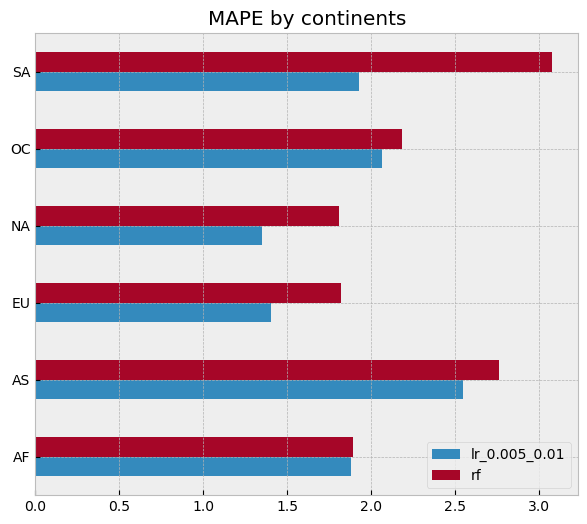

In [18]:
ind = df_out.mean().sort_values().index
feats1 = ['lr_0.005_0.01','rf']
p = df_out[feats1].plot(kind = 'barh', ylabel = '', figsize = (7,6), title = 'MAPE by continents')

### 4. MLForecast Fit Predict

In [20]:
# training
models = {
    'rf': RandomForestRegressor(random_state=0, n_estimators=100, ),
    'lr': linear_model.ElasticNet(alpha=0.005, l1_ratio=0.01),
}

    
model = MLForecast(
    models = models,
    target_transforms = [
        target_transforms.Differences([1]),
        # target_transforms.LocalStandardScaler(),
    ],
    lags = [1,2,3],
    lag_transforms = {
        1:  [
            (rolling_mean, 3),
        ],
    },
)

df_pred = model.fit(df_feats.iloc[:,:], max_horizon = None)
df_pred = model.predict(h = 3)
df_pred2 = df_pred.set_index(['ds','unique_id']).unstack()#['rf']
df_pred2

rf                                                   lr  \
unique_id       AF        AS       EU       NA     OC       SA       AF   
ds                                                                        
2023      3,449.27 33,968.18 4,475.82 7,924.15 675.98 2,560.29 3,474.55   
2024      3,486.14 34,468.61 4,380.53 7,890.82 674.98 2,561.13 3,544.38   
2025      3,519.55 34,964.65 4,274.24 7,896.36 671.57 2,563.43 3,622.06   

                                                       
unique_id        AS       EU       NA     OC       SA  
ds                                                     
2023      33,957.71 4,508.19 8,023.80 677.00 2,562.40  
2024      34,480.15 4,457.23 8,012.24 665.69 2,579.07  
2025      34,988.78 4,408.43 8,022.57 656.02 2,594.34

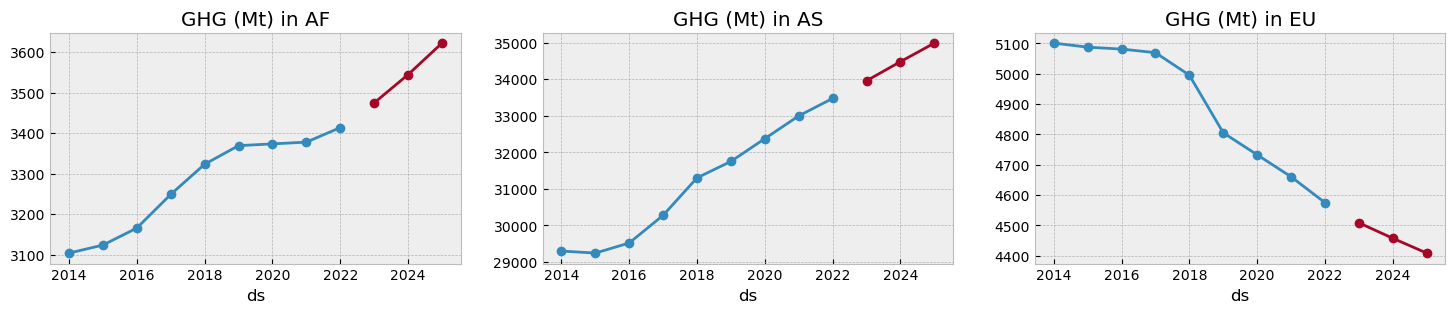

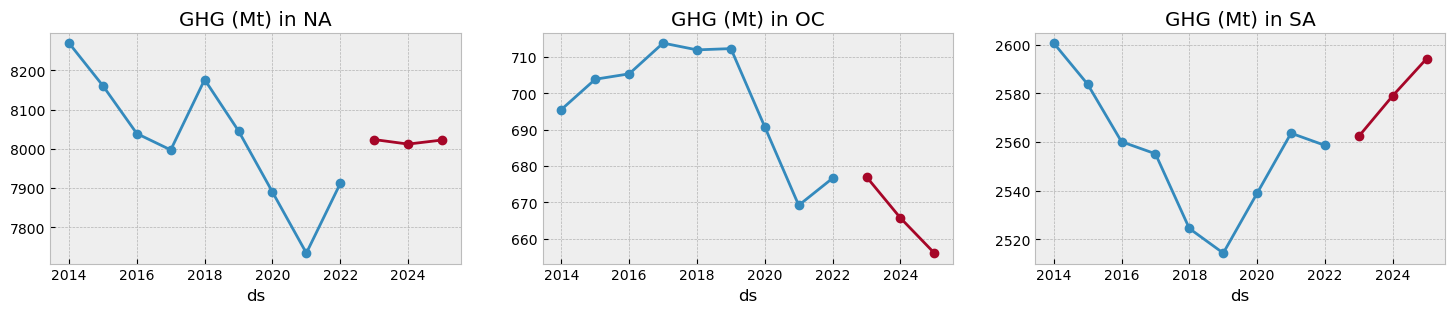

In [21]:
# predictions
for i,c in enumerate(df_res2['y'].columns):
    if i%3 == 0:
        _,ax = plt.subplots(1,3, figsize = (18,3))
    _ = df_res2['y'][c][-10:].plot(style = 'o-', ax = ax[i%3], title = 'GHG (Mt) in ' + c)
    # _ = df_pred2['rf'][c].plot(style = 'o-', ax = ax[i%3])
    _ = df_pred2['lr'][c].plot(style = 'o-', ax = ax[i%3])

### 5. Features

In [22]:
df1 = model.preprocess(df_feats)
print(df1.shape)
print(df1.isnull().sum().max())
cols = [c.replace('rolling_mean','RM').replace('window_size','WS').replace('seasonal','S').replace('season_length','SL') for c in list(df1.columns)]
df1.columns = cols
# df1[:3]

(294, 21)
0


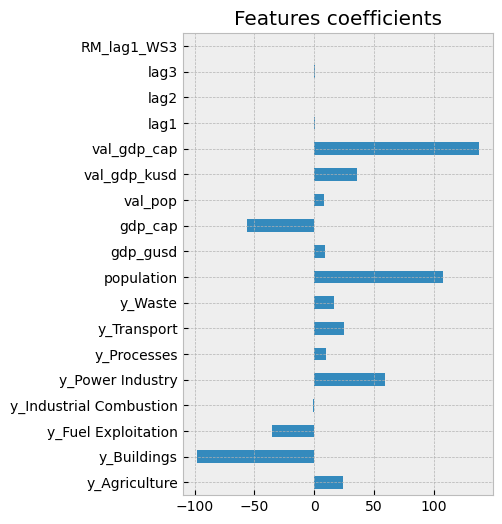

In [23]:
# coefs:
model_lr = model.models_['lr']
cols = model_lr.feature_names_in_
cols = [c.replace('rolling_mean','RM').replace('window_size','WS').replace('seasonal','S').replace('season_length','SL') for c in cols]
a = pd.Series(model_lr.coef_, index = cols).plot(kind = 'barh', figsize = (4,6), title = 'Features coefficients')

In [24]:
x = pd.Series(model_lr.coef_, index = cols)
x[x != 0]

y_Agriculture              24.16
y_Buildings               -98.17
y_Fuel Exploitation       -35.33
y_Industrial Combustion    -1.19
y_Power Industry           59.31
y_Processes                 9.75
y_Transport                24.64
y_Waste                    16.82
population                107.70
gdp_gusd                    9.26
gdp_cap                   -56.34
val_pop                     8.10
val_gdp_kusd               35.52
val_gdp_cap               137.30
lag1                        0.69
lag2                       -0.21
lag3                        0.29
RM_lag1_WS3                -0.10
dtype: float64

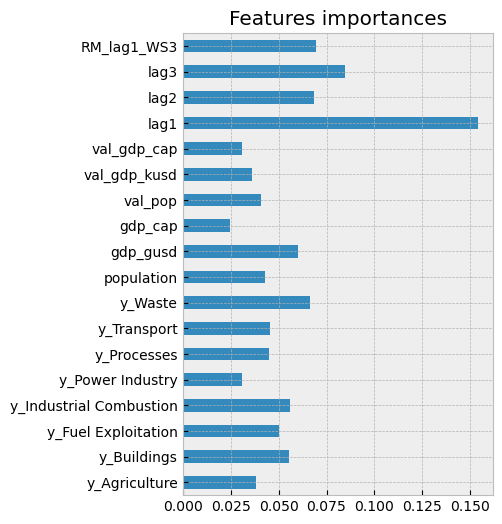

In [12]:
# coefs:
model_rf = model.models_['rf']
cols = model_lr.feature_names_in_
cols = [c.replace('rolling_mean','RM').replace('window_size','WS').replace('seasonal','S').replace('season_length','SL') for c in cols]
a = pd.Series(model_rf.feature_importances_, index = cols).plot(kind = 'barh', figsize = (4,6), title = 'Features importances')

Text(0.5, 1.0, 'Correlation matrix')

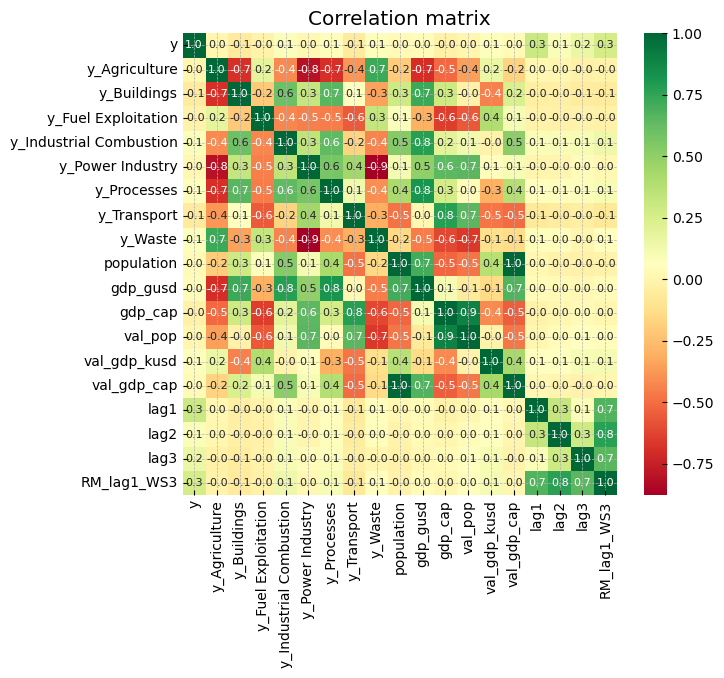

In [13]:
# correlations
df_corr = df1.iloc[:,2:].corr()
_, ax = plt.subplots(figsize = (7,6))
_ = sns.heatmap(df_corr, ax = ax, cmap = 'RdYlGn', annot = True, fmt = '.1f', annot_kws={"size": 8})
_.set_title('Correlation matrix')